# Autocodificadores

<table align='left'>
<tr><td> <img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/autoencoder_schema.jpg"> </td></tr>
</table>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np

from PIL import Image
from IPython import display

import torch
from torch import nn
from torch.optim import lr_scheduler
import torchvision

import lib.pytorch_trainer_v2 as ptt

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


## Carregamento do MNIST dataset (já está no disco)

A base de dados MNIST está disponível em: http://yann.lecun.com/exdb/mnist/
Consiste de 60 mil amostras de treinamento e 10 mil amostras de teste. Cada amostra é uma pequena imagem em níveis de cinza de tamanho 28x28 pixels com valores entre 0 e 255.

A base já está carregada e disponível em /data/datasets:

In [2]:
x_train, y_train = torch.load('/data/datasets/MNIST/processed/training.pt')
x_test,  y_test  = torch.load('/data/datasets/MNIST/processed/test.pt')

In [3]:
print(x_train.shape, x_test.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


## Treinando com pouquíssimos dados

In [4]:
if False:
    n_train_samples = 1000
    n_test_samples = 500
else:
    n_train_samples = x_train.shape[0]
    n_test_samples  = x_test.shape[0]
xx_train = x_train[:n_train_samples].float() /255.
yy_train = y_train[:n_train_samples] 
xx_test  = x_test[:n_test_samples].float() / 255.
yy_test  = y_test[:n_test_samples]

In [5]:
xx_train.shape, xx_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [6]:
xx_train.type(),yy_train.type(), xx_test.type(), yy_test.type()

('torch.FloatTensor',
 'torch.LongTensor',
 'torch.FloatTensor',
 'torch.LongTensor')

## Cria a rede

<table align='left'>
<tr><td> <img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/autoencoder_1.png" width="600pt"> </td></tr>
</table>

In [7]:
class MyAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = nn.Linear(28*28, 512)
        self.relu1 = nn.ReLU()
        self.dense2 = nn.Linear(512, 128)
        self.relu2 = nn.ReLU()
        self.dense3 = nn.Linear(128, 2)
        self.dense4 = nn.Linear(2, 128)
        self.relu3 = nn.ReLU()
        self.dense5 = nn.Linear(128, 512)
        self.relu4 = nn.ReLU()
        self.dense6 = nn.Linear(512, 28*28)
    def encode(self, x):
        x = x.view(-1, 28*28)
        x = self.dense1(x)
        x = self.relu1(x)
        x = self.dense2(x)
        x = self.relu2(x)
        x = self.dense3(x)
        return x
    def decode(self, x):
        x = self.dense4(x)
        x = self.relu3(x)
        x = self.dense5(x)
        x = self.relu4(x)
        x = self.dense6(x)
        x = x.view(-1, 28, 28)
        return x
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [8]:
model = MyAutoEncoder()
print(model)

MyAutoEncoder(
  (dense1): Linear(in_features=784, out_features=512, bias=True)
  (relu1): ReLU()
  (dense2): Linear(in_features=512, out_features=128, bias=True)
  (relu2): ReLU()
  (dense3): Linear(in_features=128, out_features=2, bias=True)
  (dense4): Linear(in_features=2, out_features=128, bias=True)
  (relu3): ReLU()
  (dense5): Linear(in_features=128, out_features=512, bias=True)
  (relu4): ReLU()
  (dense6): Linear(in_features=512, out_features=784, bias=True)
)


## Cria o trainer

In [9]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0)
savebest = ptt.ModelCheckpoint('../../models/auto_encoder_pt',reset=True, verbose=1)
trainer = ptt.DeepNetTrainer( 
                         model, 
                         criterion, 
                         optimizer=optimizer,
                         lr_scheduler=lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1),
                         callbacks = [savebest, ptt.PrintCallback()]
                        )

## Treinamento

In [10]:
retrain = False
if retrain:
    trainer.fit(n_epochs=20, Xin=xx_train, Yin=xx_train,
                valid_data=(xx_test, xx_test), batch_size=20)
else:
    trainer.load_state('/data/models/auto_encoder_pt')

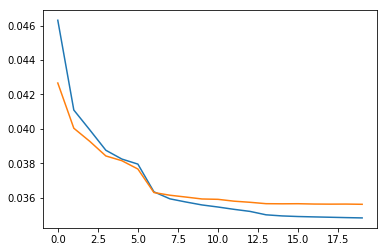

In [11]:
tra_loss = trainer.metrics['train']['losses']
val_loss = trainer.metrics['valid']['losses']
epochs = np.arange(len(tra_loss))
plt.plot(epochs, tra_loss, epochs, val_loss)

In [12]:
yy_pred = trainer.predict(xx_test)

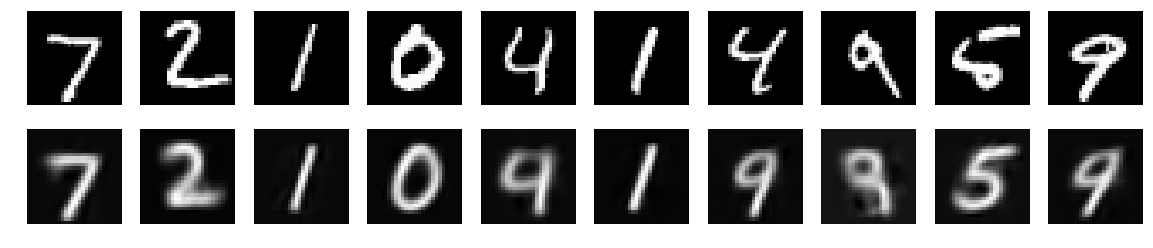

In [13]:
n = 10
plt.figure(figsize=(20, 4))
plt.gray()
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(xx_test[i].numpy().reshape(28, 28))
    plt.axis('off')

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(yy_pred[i].cpu().numpy().reshape(28, 28))
    plt.axis('off')
plt.show()

## Imagens no plano 2D

In [14]:
xin = xx_train.view(-1, 28*28)
if use_gpu:
    xin = xin.cuda()
encoded = trainer.model.encode(xin)
encoded_data = encoded.data.cpu().numpy()

In [21]:
encoded_data[:10,:]

array([[-1.8003008 , -0.64061004],
       [-0.34296763, -2.7920985 ],
       [-0.32838884,  0.15594614],
       [ 2.1171122 ,  2.3884397 ],
       [-0.5019023 ,  0.60888594],
       [-4.6672773 , -3.7674618 ],
       [ 0.06900711,  4.0791926 ],
       [-5.8003163 , -2.141754  ],
       [ 0.01514734,  2.1994464 ],
       [-0.8388585 ,  0.3618162 ]], dtype=float32)

In [36]:
def i2show(classes_to_show):
    first = True
    for c in classes_to_show:
        if first:
            index = yy_train.numpy() == c
            first = False
        else:
            index |= yy_train.numpy() == c
    return index

In [60]:
classes_to_show = np.arange(10)
index = i2show(classes_to_show)

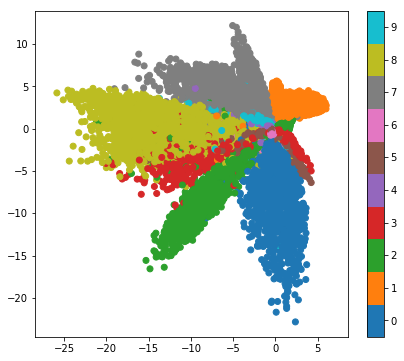

In [61]:
plt.figure(figsize=(7, 6))
plt.scatter(encoded_data[index, 0], encoded_data[index, 1], 
            c=yy_train.numpy()[index], 
            cmap=plt.cm.tab10, vmin=-.5, vmax=9.5)
plt.axis('equal')
cbar = plt.colorbar();
cbar.set_ticks(np.arange(10))
plt.show()

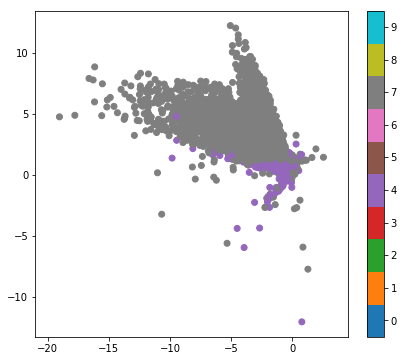

In [63]:
classes_to_show = [7,4] #np.arange(10)
index = i2show(classes_to_show)
plt.figure(figsize=(7, 6))
plt.scatter(encoded_data[index, 0], encoded_data[index, 1], 
            c=yy_train.numpy()[index], 
            cmap=plt.cm.tab10, vmin=-.5, vmax=9.5)
plt.axis('equal')
cbar = plt.colorbar();
cbar.set_ticks(np.arange(10))
plt.show()

## Imagens geradas ao percorrer uma linha reta no espaço 2D

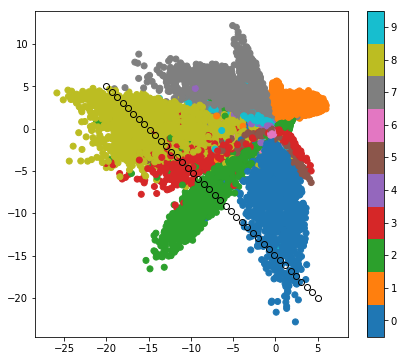

In [16]:
n = 40
x = np.linspace(-20.,   5., n)
y = np.linspace(  5., -20., n)
plt.figure(figsize=(7, 6))
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=yy_train.numpy(), cmap=plt.cm.tab10, vmin=-.5, vmax=9.5)
plt.plot(x, y, 'ko', mfc='none')
plt.axis('equal')
cbar = plt.colorbar();
cbar.set_ticks(np.arange(10))
plt.show()

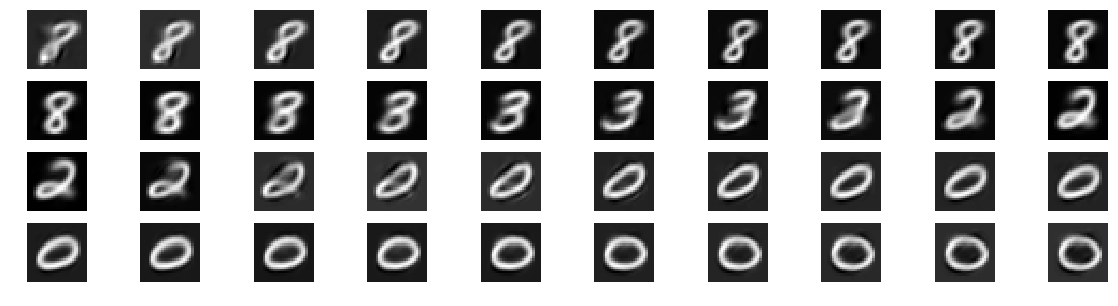

In [17]:
data = np.array([x, y]).T
data_in = torch.from_numpy(data).type(torch.FloatTensor)

if use_gpu:
    data_in = data_in.cuda()
    
out = trainer.model.decode(data_in)
out = out.view(-1, 28, 28)
                    
plt.figure(figsize=(20, 5))
plt.gray()

for i in range(n):
    ax = plt.subplot(4, n//4, i+1)
    plt.imshow(out[i].data.cpu().numpy().reshape(28, 28))
    plt.axis('off')
plt.show()

## Imagens geradas ao percorrer um círculo no espaço 2D centrado em (0,0)

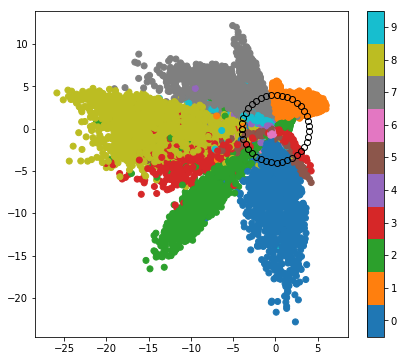

In [18]:
n = 40
phi = np.linspace(-np.pi, np.pi, n)
r = 4.
x = r * np.cos(phi)
y = r * np.sin(phi)
plt.figure(figsize=(7, 6))
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=yy_train.numpy(), cmap=plt.cm.tab10, vmin=-.5, vmax=9.5)
plt.plot(x, y, 'ko', mfc='none')
plt.axis('equal')
cbar = plt.colorbar();
cbar.set_ticks(np.arange(10))
plt.show()

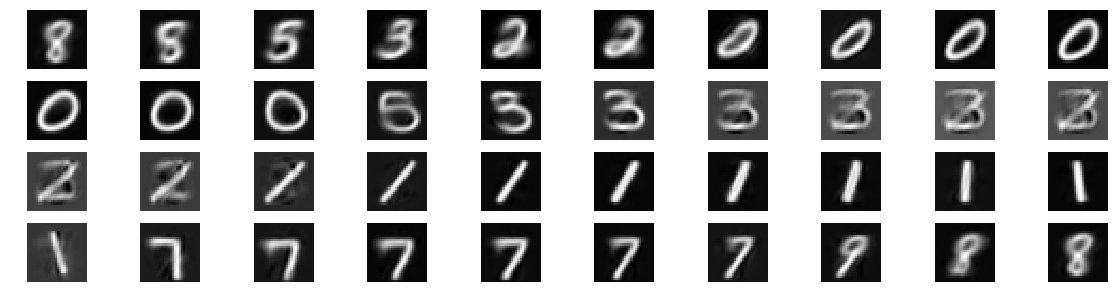

In [19]:
data = np.array([x, y]).T
data_in = torch.from_numpy(data).type(torch.FloatTensor)

if use_gpu:
    data_in = data_in.cuda()
    
out = trainer.model.decode(data_in)
out = out.view(-1, 28, 28)
                    
plt.figure(figsize=(20, 5))
plt.gray()

for i in range(n):
    ax = plt.subplot(4, n//4, i+1)
    plt.imshow(out[i].data.cpu().numpy().reshape(28, 28))
    plt.axis('off')
plt.show()

# Atividades

## Exercícios

1. Escolha um código (duas coordenadas no espaço 2D mostrado acima), e utilize o decoder (model.decoder) para mostrar qual é a saída correspondente da rede treinada.
2. Aumente o número de imagens geradas para 100 tanto ao percorrer uma linha reta como para percorrer um círculo,
   nos exemplos gerados acima e observe a melhora na interpolação entre as imagens geradas.
3. Mostre no gráfico do espaço bidimensional os códigos das images dos quatros e dos setes,
   observe que tem uma amostra quatro (roxa) bem abaixo no gráfico. Visualize esta
   amostra e procure explicar por que ela aparece ali.

In [79]:
classes_to_show = [7]
index = i2show(classes_to_show)

In [80]:
i = np.argmin(encoded_data[index,1])
i

2790

In [81]:
code = encoded_data[index][i]
c = yy_train.numpy()[index][i]

In [82]:
c

7

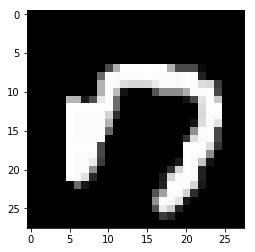

In [83]:
img = xx_train.numpy()[index][i]
plt.imshow(img,cmap='gray')